# Student Performance Prediction

Complete notebook for the project: data loading, EDA, preprocessing, model training (Random Forest), evaluation, and sample predictions.

**Instructions:** Place `StudentsPerformance.csv` in the same folder as this notebook to use the Kaggle dataset. If not present, a synthetic dataset will be generated.

## 1. Imports and setup

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

## 2. Load dataset (or generate synthetic if missing)

In [2]:
DATAFILE = 'StudentsPerformance.csv'

def load_or_create_dataset(path=DATAFILE):
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)
        print(f"Dataset loaded. Shape: {df.shape}")
        return df
    else:
        print(f"Dataset file '{path}' not found. Generating a synthetic small dataset for demo...")
        rng = np.random.RandomState(42)
        n = 500
        genders = rng.choice(['male','female'], size=n)
        parent_edu = rng.choice(["bachelor's degree","some college","master's degree","high school","associate's degree"], size=n)
        lunch = rng.choice(['standard','free/reduced'], size=n, p=[0.7,0.3])
        test_prep = rng.choice(['none','completed'], size=n, p=[0.6,0.4])
        math = np.clip((rng.normal(65,15,size=n) + (test_prep=='completed')*5 + (genders=='male')*2).round().astype(int), 0, 100)
        reading = np.clip((rng.normal(68,12,size=n) + (test_prep=='completed')*4 + (genders=='female')*3).round().astype(int), 0, 100)
        writing = np.clip((rng.normal(66,13,size=n) + (test_prep=='completed')*3 + (genders=='female')*2).round().astype(int), 0, 100)
        df = pd.DataFrame({
            'gender': genders,
            'parental level of education': parent_edu,
            'lunch': lunch,
            'test preparation course': test_prep,
            'math score': math,
            'reading score': reading,
            'writing score': writing
        })
        print(f"Synthetic dataset generated. Shape: {df.shape}")
        return df

df = load_or_create_dataset()
df.head()

Loading dataset from StudentsPerformance.csv ...
Dataset loaded. Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 3. Create target variable (performance level)

In [3]:
def create_target(df):
    df = df.copy()
    df['total_score'] = df[['math score','reading score','writing score']].sum(axis=1)
    df['avg_score'] = df['total_score'] / 3.0
    bins = [0, 60, 80, 1000]
    labels = ['Low', 'Medium', 'High']
    df['performance_level'] = pd.cut(df['avg_score'], bins=bins, labels=labels, include_lowest=True)
    return df

df = create_target(df)
df[['math score','reading score','writing score','avg_score','performance_level']].head()

,math score,reading score,writing score,avg_score,performance_level
0,72,72,74,72.666667,Medium
1,69,90,88,82.333333,High
2,90,95,93,92.666667,High
3,47,57,44,49.333333,Low
4,76,78,75,76.333333,Medium


## 4. Exploratory Data Analysis (EDA) — basic visuals

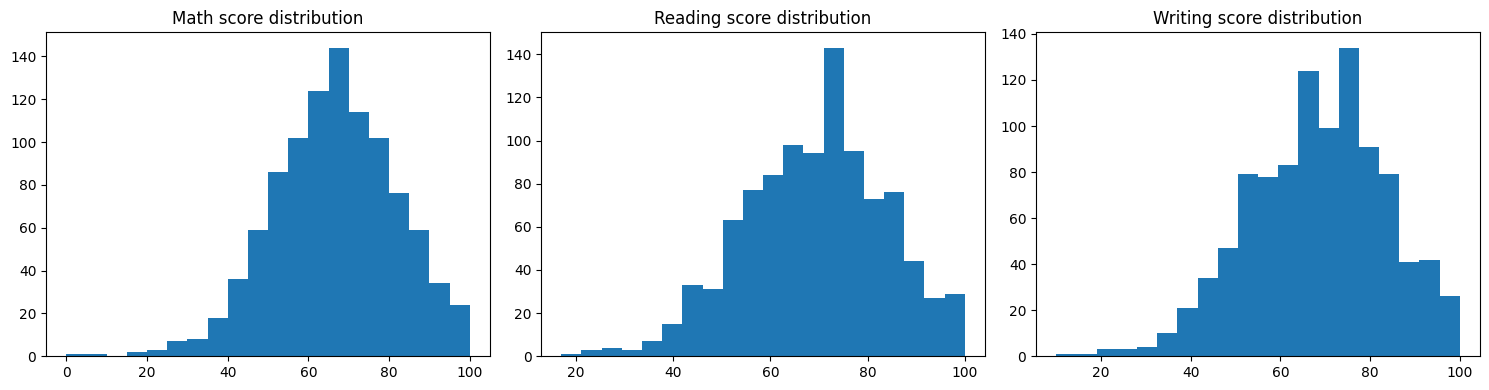

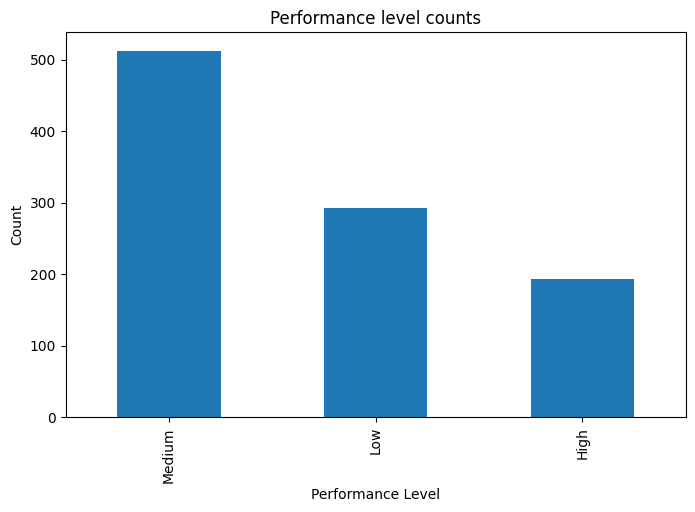

,math score,reading score,writing score
test preparation course,,,
completed,69.695531,73.893855,74.418994
none,64.077882,66.534268,64.504673


In [4]:
# Distribution of scores
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].hist(df['math score'], bins=20)
axes[0].set_title('Math score distribution')
axes[1].hist(df['reading score'], bins=20)
axes[1].set_title('Reading score distribution')
axes[2].hist(df['writing score'], bins=20)
axes[2].set_title('Writing score distribution')
plt.tight_layout()
plt.show()

# Performance level counts
df['performance_level'].value_counts().plot(kind='bar')
plt.title('Performance level counts')
plt.xlabel('Performance Level')
plt.ylabel('Count')
plt.show()

# Mean scores by test preparation course
df.groupby('test preparation course')[['math score','reading score','writing score']].mean()

## 5. Preprocessing and train/test split

In [6]:
features = ['gender','parental level of education','lunch','test preparation course',
            'math score','reading score','writing score']
target = 'performance_level'

X = df[features]
y = df[target].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cat_features = ['gender','parental level of education','lunch','test preparation course']
num_features = ['math score','reading score','writing score']

cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

## 6. Model pipeline (Random Forest)

In [7]:
clf = Pipeline(steps=[('pre', preprocessor),
                      ('model', RandomForestClassifier(n_estimators=200, random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {acc:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Test Accuracy: 0.9550

Classification Report:
               precision    recall  f1-score   support

        High       0.95      0.95      0.95        39
         Low       0.95      0.97      0.96        59
      Medium       0.96      0.95      0.96       102

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



## 7. Confusion matrix and feature importance

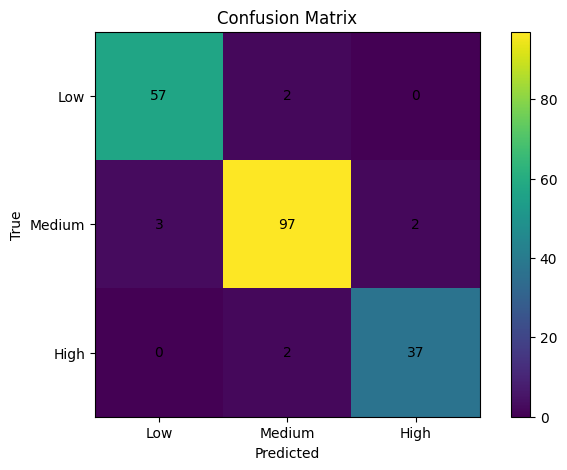

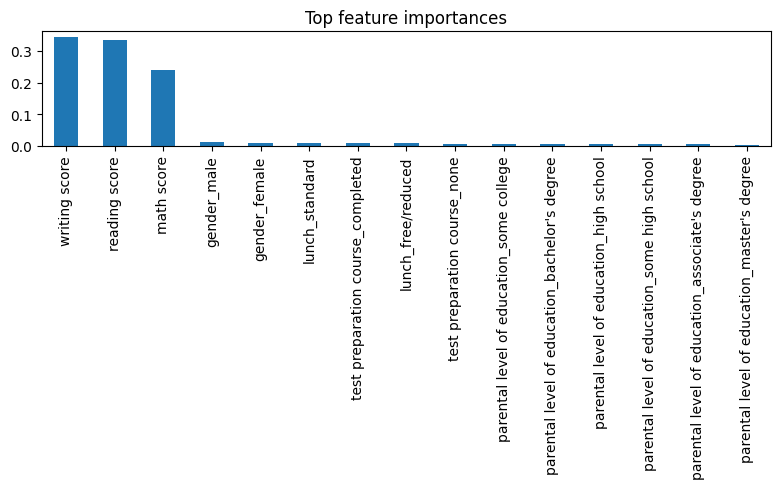

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low','Medium','High'])
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(3), ['Low','Medium','High'])
plt.yticks(np.arange(3), ['Low','Medium','High'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature importances
model = clf.named_steps['model']
pre = clf.named_steps['pre']
num_features = pre.transformers_[0][2]
ohe = pre.transformers_[1][1]
cat_features = pre.transformers_[1][2]
try:
    ohe_feature_names = ohe.get_feature_names_out(cat_features)
except Exception:
    ohe_feature_names = ohe.get_feature_names(cat_features)
feature_names = list(num_features) + list(ohe_feature_names)
importances = model.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.head(15).plot(kind='bar')
plt.title('Top feature importances')
plt.tight_layout()
plt.show()

## 8. Save trained pipeline and sample results

In [9]:
# Save pipeline
joblib.dump(clf, 'student_perf_model.pkl')
print('Saved pipeline to student_perf_model.pkl')

# Save sample results
results = X_test.copy()
results['y_true'] = y_test.values
results['y_pred'] = y_pred
results.to_csv('student_performance_project_report.csv', index=False)
print('Saved test set results to student_performance_project_report.csv')

Saved pipeline to student_perf_model.pkl
Saved test set results to student_performance_project_report.csv


## 9. Predict new samples (examples)

In [10]:
samples = pd.DataFrame([
    {'gender':'female','parental level of education':"bachelor's degree",'lunch':'standard','test preparation course':'completed','math score':88,'reading score':92,'writing score':90},
    {'gender':'male','parental level of education':'high school','lunch':'free/reduced','test preparation course':'none','math score':45,'reading score':48,'writing score':42},
])
preds = clf.predict(samples)
proba = clf.predict_proba(samples)
samples['predicted_performance'] = preds
samples['confidence'] = proba.max(axis=1)
samples

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,predicted_performance,confidence
0,female,bachelor's degree,standard,completed,88,92,90,High,1.0
1,male,high school,free/reduced,none,45,48,42,Low,1.0


## 10. Next steps and ideas
- Try other models (XGBoost, Logistic Regression) and compare metrics.
- Tune hyperparameters with GridSearchCV.
- Add more features (attendance, study hours) if available.
- Deploy as a Streamlit app for real-time predictions.